# Interactive Portfolio Optimization System

This notebook helps you build an optimal investment portfolio based on:
- **Your chosen stocks**
- **Your risk preference (1-10 scale)**

We use **Modern Portfolio Theory (MPT)** and **CVXPY** optimization to find the best portfolio weights.

---

## Step 1: Install Required Libraries

In [73]:
# Install required packages
!pip install yfinance cvxpy pandas numpy matplotlib seaborn -q
print("All packages installed!")

All packages installed!


## Step 2: Import Libraries

In [97]:
import yfinance as yf
import pandas as pd
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt
import seaborn as sns

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
print("Libraries imported")

Libraries imported


---
## Step 3: Enter Your Stocks

**Examples:**
- Indian (NSE): `RELIANCE.NS`, `TCS.NS`, `HDFCBANK.NS`, `INFY.NS`, `GOLDBEES.NS`
- US: `AAPL`, `GOOGL`, `MSFT`, `AMZN`, `TSLA`

In [75]:
# USER INPUT: Number of stocks
num_stocks = int(input("How many stocks do you want? (2-10): "))

# Get ticker symbols
tickers = []
print(f"\nEnter {num_stocks} stock ticker symbols:")
for i in range(num_stocks):
    ticker = input(f"Stock {i+1}: ").strip().upper()
    tickers.append(ticker)

print(f"\n Selected Stocks: {tickers}")

How many stocks do you want? (2-10): 2

Enter 2 stock ticker symbols:
Stock 1: SAIL.NS
Stock 2: GAIL.NS

 Selected Stocks: ['SAIL.NS', 'GAIL.NS']


---
## Step 4: Download Historical Data

In [76]:
# Download 3 years of data
print("Downloading data...")
data = yf.download(tickers, period="3y", progress=False)

# Get closing prices
if 'Close' in data.columns:
    prices = data['Close']
else:
    prices = data

# Clean data
prices = prices.dropna()

print(f"Downloaded {len(prices)} days of data")
print(f"\nDate range: {prices.index[0].date()} to {prices.index[-1].date()}")
prices.tail()

/tmp/ipython-input-2997328384.py:3: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(tickers, period="3y", progress=False)


Downloaded 741 days of data

Date range: 2023-01-30 to 2026-01-29


Ticker,GAIL.NS,SAIL.NS
Date,,
2026-01-22,163.570007,151.649994
2026-01-23,160.809998,149.029999
2026-01-27,159.979996,155.559998
2026-01-28,168.139999,155.740005
2026-01-29,167.380005,157.179993


---
## Step 5: Calculate Returns & Risk Metrics

In [98]:
# Calculate log returns
log_returns = np.log(prices / prices.shift(1)).dropna()

# Annualized metrics
trading_days = 252

# Expected annual return
mu = log_returns.mean() * trading_days

# Annual volatility
sigma = log_returns.std() * np.sqrt(trading_days)

# Covariance matrix
cov_matrix = log_returns.cov() * trading_days

# Display results
print("INDIVIDUAL ASSET RETURNS&RISKS")
for ticker in tickers:
    print(f"{ticker:12}  Return: {mu[ticker]*100:7.2f}% Risk: {sigma[ticker]*100:7.2f}%")

INDIVIDUAL ASSET RETURNS&RISKS
SAIL.NS       Return:   21.73% Risk:   38.79%
GAIL.NS       Return:   23.08% Risk:   31.65%


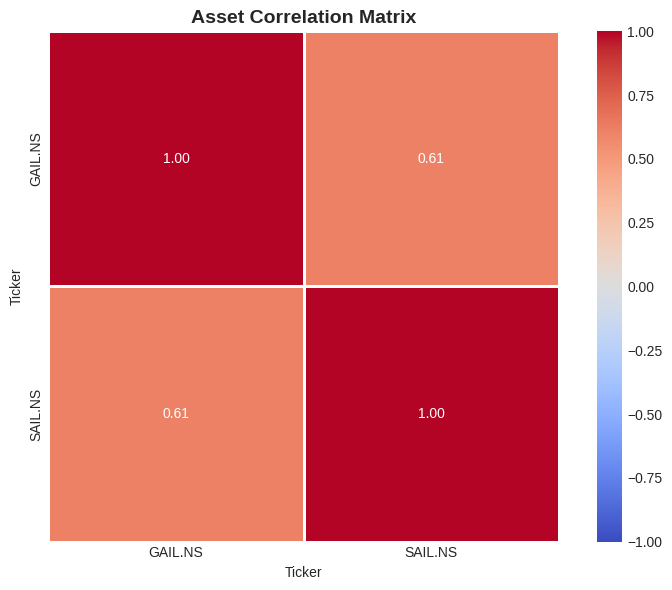

In [78]:
# Show correlation matrix
corr_matrix = log_returns.corr()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm',
            vmin=-1, vmax=1, center=0, square=True, linewidths=1)
plt.title('Asset Correlation Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

---
## Step 6: Enter Your Risk Preference

| Scale | Risk Level | Strategy |
|-------|------------|----------|
| 1-3 | Conservative | Minimize risk, accept lower returns |
| 4-6 | Moderate | Balance risk & return |
| 7-10 | Aggressive | Maximize returns, accept higher risk |

In [79]:
# Risk Preference (1-10)
risk_preference = int(input("Enter your risk preference (1-10, where 10 = highest risk): "))

# Validate input
risk_preference = max(1, min(10, risk_preference))
print(f"\n Risk Preference: {risk_preference}/10")

Enter your risk preference (1-10, where 10 = highest risk): 5

 Risk Preference: 5/10


---
## Step 7: Portfolio Optimization with CVXPY


In [104]:
# Convert to numpy arrays
mu_arr = mu.values
Sigma = cov_matrix.values
n = len(tickers)

# FUNCTION: Find portfolio for target return
def optimize_portfolio(target_return):
    """
    Find minimum variance portfolio for a given target return using CVXPy
    """
    w = cp.Variable(n)  # Portfolio weights

    # Objective: Minimize portfolio variance
    portfolio_variance = cp.quad_form(w, Sigma)
    objective = cp.Minimize(portfolio_variance)

    # Constraints
    constraints = [
        cp.sum(w) == 1,              # Weights sum to 100%
        w >= 0,                       # No short selling
        w @ mu_arr == target_return   # Target return
    ]

    # Solve
    problem = cp.Problem(objective, constraints)
    problem.solve()

    if w.value is None:
        return None

    return w.value

# FUNCTION: Find minimum variance portfolio
def find_min_variance_portfolio():
    w = cp.Variable(n)
    objective = cp.Minimize(cp.quad_form(w, Sigma))
    constraints = [cp.sum(w) == 1, w >= 0]
    problem = cp.Problem(objective, constraints)
    problem.solve()
    return w.value

# FUNCTION: Find balanced portfolio
def find_balanced_portfolio():
    # For a balanced portfolio, we can select a portfolio from the middle of the efficient frontier
    if not efficient_weights: # Check if efficient_weights is empty
        return None

    mid_idx = len(efficient_weights) // 2
    return efficient_weights[mid_idx]

print("Optimization functions defined")

Optimization functions defined


In [105]:
# Generate Efficient Frontier
print("Calculating efficient frontier...")

# Get return range
min_ret = np.min(mu_arr)
max_ret = np.max(mu_arr)
target_returns = np.linspace(min_ret, max_ret, 100)

# Store efficient frontier points
efficient_returns = []
efficient_volatilities = []
efficient_weights = []

for target_ret in target_returns:
    weights = optimize_portfolio(target_ret)
    if weights is not None:
        port_ret = np.dot(weights, mu_arr)
        port_vol = np.sqrt(np.dot(weights.T, np.dot(Sigma, weights)))
        efficient_returns.append(port_ret)
        efficient_volatilities.append(port_vol)
        efficient_weights.append(weights)

efficient_returns = np.array(efficient_returns)
efficient_volatilities = np.array(efficient_volatilities)

print(f"Efficient frontier calculated")

Calculating efficient frontier...
Efficient frontier calculated


In [106]:
# Select Portfolio Based on Risk Preference

if risk_preference <= 3:
    # CONSERVATIVE: Minimum variance portfolio
    strategy = "Minimum Risk "
    optimal_weights = find_min_variance_portfolio()

elif risk_preference <= 6:
    # MODERATE
    strategy = "Balanced"
    optimal_weights = find_balanced_portfolio()

else:
    # AGGRESSIVE: Higher return portfolio
    strategy = "High Return"
    # Map risk 7-10 to higher return targets
    risk_factor = (risk_preference - 6) / 4  # 0.25 to 1.0
    target_idx = int(len(efficient_weights) * (0.7 + 0.3 * risk_factor))
    target_idx = min(target_idx, len(efficient_weights) - 1)
    optimal_weights = efficient_weights[target_idx]

# Calculate portfolio metrics
portfolio_return = np.dot(optimal_weights, mu_arr)
portfolio_volatility = np.sqrt(np.dot(optimal_weights.T, np.dot(Sigma, optimal_weights)))
sharpe_ratio = portfolio_return / portfolio_volatility

print(f"YOUR OPTIMAL PORTFOLIO")
print(f"Strategy: {strategy}")
print(f"Risk Preference: {risk_preference}/10")
print(f"\nExpected Annual Return: {portfolio_return*100:.2f}%")
print(f"Expected Annual Risk:   {portfolio_volatility*100:.2f}%")

print("PORTFOLIO WEIGHTS:")
for i, ticker in enumerate(tickers):
    weight_pct = optimal_weights[i] * 100

    print(f"{ticker:12} {weight_pct:6.2f}%")

YOUR OPTIMAL PORTFOLIO
Strategy: Balanced
Risk Preference: 5/10

Expected Annual Return: 22.41%
Expected Annual Risk:   31.60%
PORTFOLIO WEIGHTS:
SAIL.NS       50.51%
GAIL.NS       49.49%


---
## Step 8: Visualize Portfolio on the Efficient Frontier

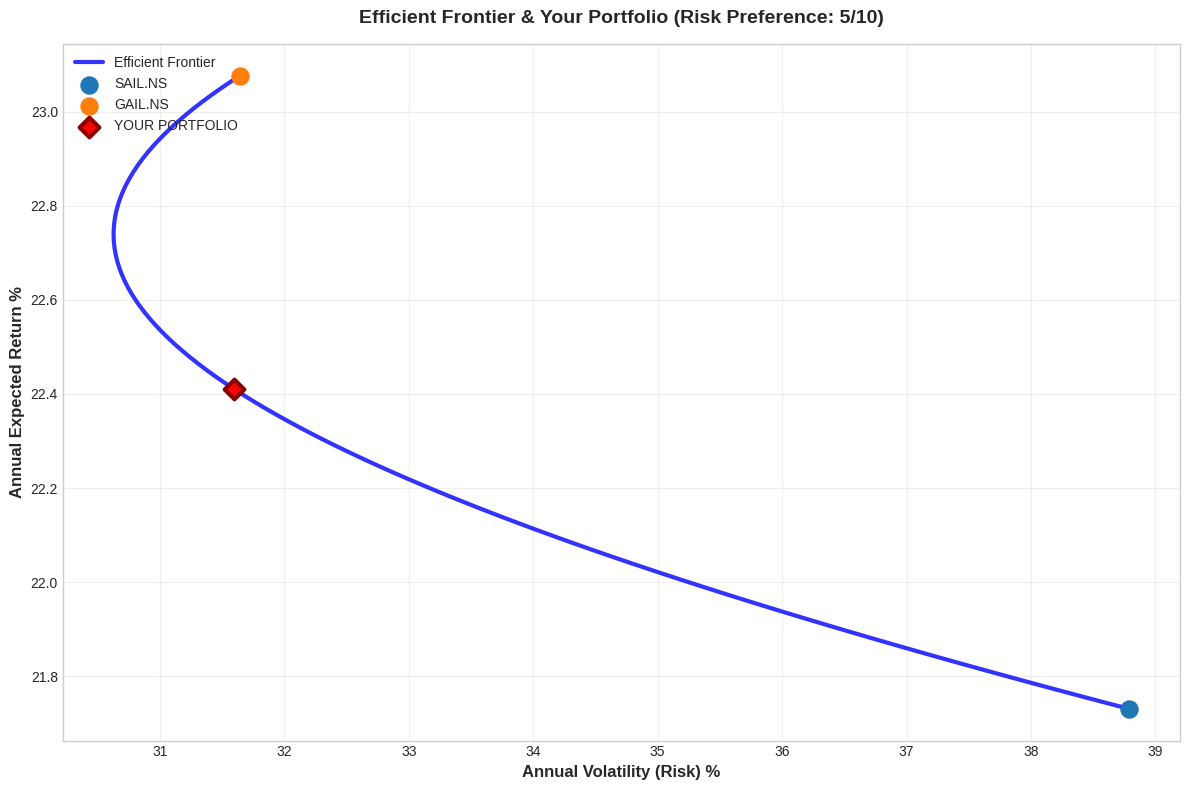

In [107]:
# Create the efficient frontier plot
plt.figure(figsize=(12, 8))

# Plot efficient frontier
plt.plot(efficient_volatilities * 100, efficient_returns * 100,
         'b-', linewidth=3, label='Efficient Frontier', alpha=0.8)

# Plot individual assets
for i, ticker in enumerate(tickers):
    plt.scatter(sigma[ticker] * 100, mu[ticker] * 100,
                s=150, marker='o', label=ticker, zorder=5)

# Plot YOUR portfolio
plt.scatter(portfolio_volatility * 100, portfolio_return * 100,
            s=100, color='red', marker='D', edgecolors='darkred',
            linewidths=3, label='YOUR PORTFOLIO', zorder=10)

plt.xlabel('Annual Volatility (Risk) %', fontsize=12, fontweight='bold')
plt.ylabel('Annual Expected Return %', fontsize=12, fontweight='bold')
plt.title(f'Efficient Frontier & Your Portfolio (Risk Preference: {risk_preference}/10)',
          fontsize=14, fontweight='bold', pad=15)
plt.legend(loc='upper left', fontsize=10, framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

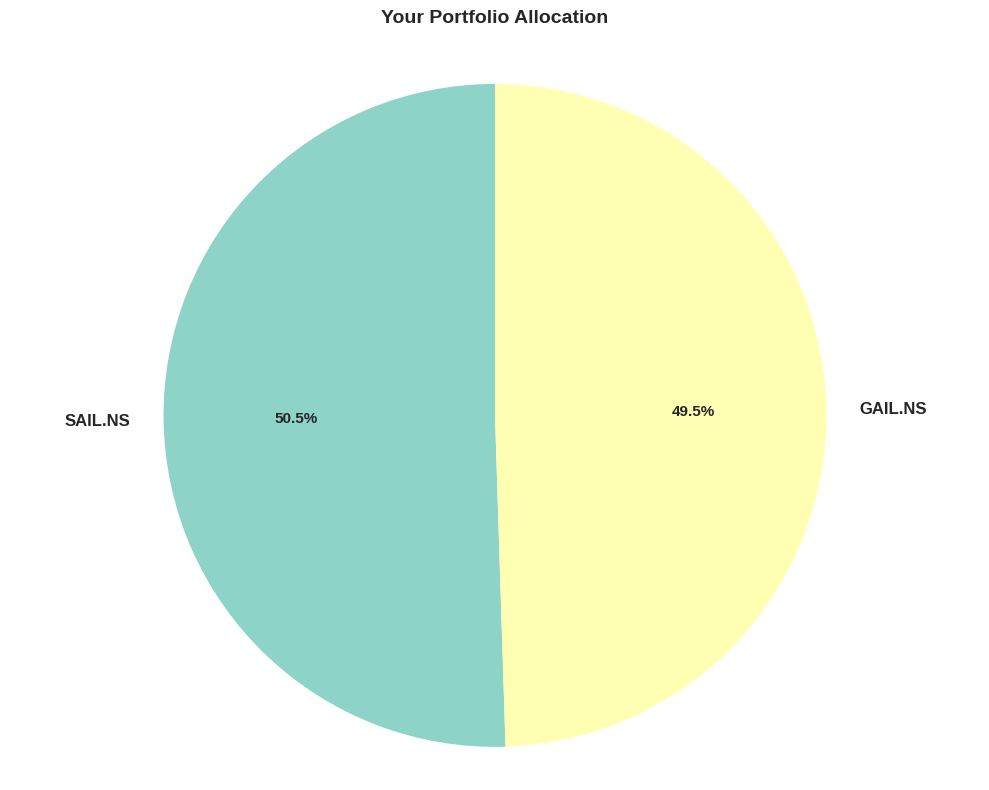

In [108]:
# Portfolio allocation pie chart
plt.figure(figsize=(10, 8))

# Filter small weights
labels = []
sizes = []
for i, ticker in enumerate(tickers):
    if optimal_weights[i] >= 0.01:  # Show weights >= 1%
        labels.append(ticker)
        sizes.append(optimal_weights[i] * 100)

colors = plt.cm.Set3(range(len(labels)))

wedges, texts, autotexts = plt.pie(
    sizes, labels=labels, autopct='%1.1f%%',
    startangle=90, colors=colors,
    textprops={'fontsize': 12, 'weight': 'bold'}
)

for autotext in autotexts:
    autotext.set_fontsize(11)
    autotext.set_weight('bold')

plt.title('Your Portfolio Allocation', fontsize=14, fontweight='bold', pad=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

---
## Step 9: Summary Report

In [109]:
# Final summary

print("PORTFOLIO OPTIMIZATION SUMMARY")

print(f"\nSelected Stocks: {tickers}")
print(f"Risk Preference: {risk_preference}/10 ({strategy})")

print(f"\nEXPECTED PERFORMANCE:")
print(f"Annual Return:{portfolio_return*100:>7.2f}%")
print(f"Annual Risk:{portfolio_volatility*100:>7.2f}%")

print(f"\nRECOMMENDED ALLOCATION:")
for i, ticker in enumerate(tickers):
    if optimal_weights[i] >= 0.005:  # Show weights >= 0.5%
        print(f"{ticker:12}: {optimal_weights[i]*100:6.2f}%")

print("\n Disclaimer: This is for educational purposes only.")
print("   Past performance does not guarantee future results.")
print("   P.S:Always consult a financial advisor before investing.")

PORTFOLIO OPTIMIZATION SUMMARY

Selected Stocks: ['SAIL.NS', 'GAIL.NS']
Risk Preference: 5/10 (Balanced)

EXPECTED PERFORMANCE:
Annual Return:  22.41%
Annual Risk:  31.60%

RECOMMENDED ALLOCATION:
SAIL.NS     :  50.51%
GAIL.NS     :  49.49%

 Disclaimer: This is for educational purposes only.
   Past performance does not guarantee future results.
   P.S:Always consult a financial advisor before investing.
